In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from PIL import Image
import pickle
import matplotlib.pyplot as plt


In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = [img for img in os.listdir(image_dir) if img.endswith(".jpg") or img.endswith(".png")]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [22]:
# Transformation to apply on the images (resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset from the test directory
dataset = CustomImageDataset(image_dir="./test", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [23]:
# Load pre-trained VGG-19 and ResNet-50 models
vgg_model = models.vgg19(pretrained=True).features.eval()
resnet_model = models.resnet50(pretrained=True).eval()

# Ensure no gradients are computed
for param in vgg_model.parameters():
    param.requires_grad = False

for param in resnet_model.parameters():
    param.requires_grad = False


D:\python install\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Nawaz sheriff/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [24]:
def extract_features(model, image):
    with torch.no_grad():
        features = model(image.unsqueeze(0))
    return features.squeeze().cpu().numpy()

# Extract features from the test directory using VGG and ResNet
vgg_features = []
resnet_features = []

for image in dataloader:
    vgg_feat = extract_features(vgg_model, image[0])
    resnet_feat = extract_features(resnet_model, image[0])
    
    vgg_features.append(vgg_feat)
    resnet_features.append(resnet_feat)

# Save the features as .pkl files
with open('weights_vgg.pkl', 'wb') as f:
    pickle.dump(vgg_features, f)

with open('weights_resnet.pkl', 'wb') as f:
    pickle.dump(resnet_features, f)


VGG-19 Feature Map Shape: (512, 7, 7)
ResNet-50 Feature Map Shape: (1000,)


TypeError: Invalid shape () for image data

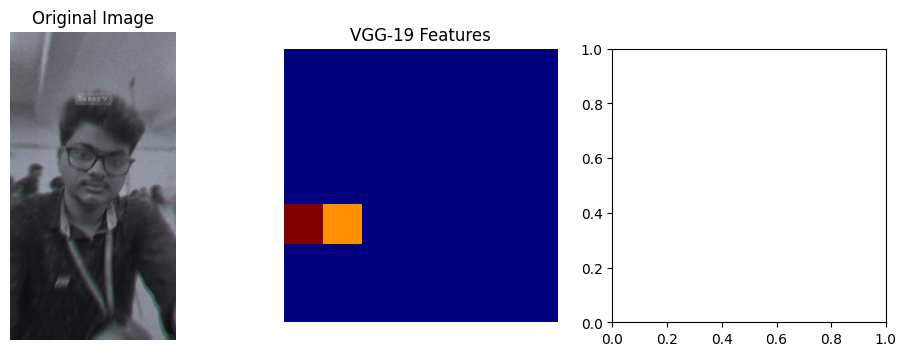

In [27]:
def overlay_features(image_path, vgg_file="weights_vgg.pkl", resnet_file="weights_resnet.pkl"):
    # Load pre-extracted features
    vgg_feat = pickle.load(open(vgg_file, "rb"))
    resnet_feat = pickle.load(open(resnet_file, "rb"))

    # Debug: Check the shapes of the extracted feature maps
    print(f"VGG-19 Feature Map Shape: {vgg_feat[0].shape}")
    print(f"ResNet-50 Feature Map Shape: {resnet_feat[0].shape}")

    # Open the test image
    image = Image.open(image_path).convert("RGB")

    # Visualize the results
    plt.figure(figsize=(12, 4))
    
    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Visualize VGG-19 features (use only one channel of the feature map for simplicity)
    plt.subplot(1, 3, 2)
    plt.imshow(vgg_feat[0][0], cmap="jet")  # Use the first channel of the first feature map
    plt.title("VGG-19 Features")
    plt.axis("off")

    # Visualize ResNet-50 features (use only one channel of the feature map for simplicity)
    plt.subplot(1, 3, 3)
    plt.imshow(resnet_feat[0][0], cmap="jet")  # Use the first channel of the first feature map
    plt.title("ResNet-50 Features")
    plt.axis("off")

    plt.show()

# Overlay features on the image
overlay_features('./PROFILE.jpg')


In [33]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define a function to load and preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Define a function to overlay the features
def overlay_features(image_path, vgg_file, resnet_file):
    # Load the image
    img_tensor = preprocess_image(image_path)
    
    # Load models
    vgg_model = models.vgg19(pretrained=True).features
    resnet_model = models.resnet50(pretrained=True)
    
    # Extract VGG-19 features
    vgg_model.eval()
    with torch.no_grad():
        vgg_feat = vgg_model(img_tensor)
    
    # Extract ResNet-50 features from layer2[2].conv3 (a convolutional layer with 256 channels)
    resnet_model.eval()
    with torch.no_grad():
        resnet_feat = resnet_model.layer2[2].conv3(resnet_model.layer2[2].relu(resnet_model.layer2[2].bn2(resnet_model.layer2[2].conv2(resnet_model.layer2[1].relu(resnet_model.layer2[0].conv1(resnet_model.layer1[0].conv1(resnet_model.conv1(img_tensor)))))))))
    
    # Visualize VGG-19 features (use only the first channel of the feature map)
    plt.subplot(1, 3, 1)
    plt.imshow(vgg_feat[0][0].cpu().numpy(), cmap="jet")  # Use the first channel of the first feature map
    plt.title("VGG-19 Features")
    plt.axis("off")

    # Visualize ResNet-50 features (use only the first channel of the feature map)
    plt.subplot(1, 3, 2)
    plt.imshow(resnet_feat[0][0].cpu().numpy(), cmap="jet")  # Use the first channel of the first feature map
    plt.title("ResNet-50 Features")
    plt.axis("off")

    plt.show()

# Example usage
overlay_features('./PROFILE.jpg', 'weights_vgg.pkl', 'weights_resnet.pkl')


SyntaxError: unmatched ')' (2752675710.py, line 36)